[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Space-Dream-42/brainTumourProject/blob/main/Code/First_Model_UNet.ipynb)

## First approach: UNet  

In [1]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
from torchvision.datasets.vision import StandardTransform
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torch.optim import Adam

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd 
from PIL import Image
import matplotlib.pyplot as plt 
%matplotlib inline 
import json
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import SimpleITK as sitk

from Dataset_Utils import BraTS_TrainingDataset
from Dataset_Utils import BraTS_TestDataset
from Dataset_Utils import plot_batch

from unet_short import UNet
from mateusbuda_utils import dsc, dsc_per_volume
from mateusbuda_loss import DiceLoss
device = 'cuda:0'

In [2]:
torch.manual_seed(0)

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060 Laptop GPU'

## Data loading setup

In [5]:
# PATH
dataset_path = '../Task01_BrainTumour/cropped'

train_data = BraTS_TrainingDataset(dataset_path, 30, 42)
test_data = BraTS_TestDataset(dataset_path, 30, 42)

../Task01_BrainTumour/cropped\imagesTr
../Task01_BrainTumour/cropped\labelsTr
../Task01_BrainTumour/cropped\imagesTr
../Task01_BrainTumour/cropped\labelsTr


In [6]:
trainloader = torch.utils.data.DataLoader(
    train_data, batch_size=20, shuffle=True)

testloader = torch.utils.data.DataLoader(
    test_data, batch_size=20, shuffle=True)

train_iter = iter(trainloader)
test_iter = iter(testloader)

In [7]:
sample_batch = test_iter.next()
print(sample_batch['image'].shape)
print(sample_batch['label'].shape)
# plot_batch(sample_batch, num_rows=2, height=75)

torch.Size([20, 4, 155, 192, 192])
torch.Size([20, 1, 155, 192, 192])


## Create the model

In [8]:
# predefined models:
# https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/
# https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/spleen_segmentation_3d.ipynb

# unet implementation
# https://github.com/milesial/Pytorch-UNet

In [8]:
# taken from https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch/notebook
def dice_loss_one_image(inputs, targets, smooth=1):
    inputs = torch.sigmoid(inputs)       
        
    #flatten label and prediction tensors
    inputs = inputs.view(-1)
    targets = targets.view(-1)
    
    intersection = (inputs * targets).sum()                            
    dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
    return 1 - dice

In [9]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets):
        
        loss_count = 0
        for i in range(len(inputs[0])):
            current_class = targets.clone()
            current_class[current_class!=i] = 0
            current_class[current_class==i] = 1
            loss_count += dice_loss_one_image(inputs[:, i], current_class)
        
        return loss_count/4

In [11]:
device = 'cuda:0'
loaders = {"train": trainloader, "valid": testloader}
unet = UNet(in_channels=4, out_channels=4, init_features=32)
unet.to(device)
dice_loss = DiceLoss()
best_validation_dsc = 0.0
optimizer = optim.Adam(unet.parameters(), lr=0.0001)
loss_train = []
loss_valid = []

step = 0


for epoch in range(5):
    for phase in ["train"]:
        if phase == "train":
            unet.train()
        else:
            unet.eval()

        validation_pred = []
        validation_true = []

        for i, data in enumerate(loaders[phase]):
            if phase == "train":
                step += 1
            print(step*20)
            x_whole = data['image']
            y_true_whole = data['label']
            loss_train = []
            for i in range(len(x_whole[0, 0])):
                x, y_true = x_whole[:, :, i, :, :].to(device), y_true_whole[:, :, i, :, :].to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    y_pred = unet(x)
                    y_true = y_true[:, 0, :, :].type(torch.LongTensor).to(device)
                    loss = dice_loss(y_pred, y_true)
                    if phase == "train":
                        loss_train.append(loss.item())
                        loss.backward()
                        optimizer.step()
            print(np.mean(loss_train))
        torch.save(unet.state_dict(), '../Saved_Models/model_weights_%i' % epoch)

20
0.7977109447602303
40
0.7870375194857198
60
0.7723287243996897
80
0.7598086714744567
100
0.7556573287133248
120
0.7440833707009592
140
0.7361104992128188
160
0.7244930644189158
180
0.7061432457739307
200
0.6991620782882937
220
0.6835800067070992
240
0.6635718884006623
260
0.6554424182061226
280
0.634023969019613
300
0.6288413201608966
320
0.6163812052819037
340
0.5919472584801335
360
0.5648211015808967
380
0.5741803688387717
400
0.5260742598964322
420
0.5403751569409524
440
0.5260780749782439
460
0.5601266109174298
480
0.5515573261245604
500
0.5013362943164764
520
0.5594954692548321
540
0.47425649166107176
560
0.513975602580655
580
0.4640586781886316
600
0.5057794128694842
620
0.45728591920868045
640
0.5356289678042935
660
0.4791096349877696
680
0.4858187448593878
700
0.4885829739032253
720
0.48642852854344154
740
0.45798814642813895
760
0.5021438887042384
780
0.4484183269162332
800
0.5812324546998547
820
0.512526120485798
840
0.4671474482743971
860
0.49246041678613234
880
0.4684673

In [10]:
unet_loaded = UNet(in_channels=4, out_channels=4, init_features=32)
unet_loaded.load_state_dict(torch.load('../Saved_Models/model_weights_4'))
unet_loaded.to(device)

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

# Evaluation

mean of the % of the intercept of all classes:

In [32]:
class Dice_Metric(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(Dice_Metric, self).__init__()

    def forward(self, inputs, targets):
        
        loss_count = []
        for i in range(len(inputs[0])):
            current_class = targets.clone()
            current_class[current_class!=i] = 0
            current_class[current_class==i] = 1
            loss_count.append(1-dice_loss_one_image(inputs[:, i], current_class).cpu().item())
        
        return loss_count

In [38]:
#evaluation
dice_loss = Dice_Metric()
loss_test = []
loaders = {"train": trainloader, "valid": testloader}
for i, data in enumerate(loaders['valid']):
    x_whole = data['image']
    y_true_whole = data['label']
    for i in range(len(x_whole[0, 0])):
        x, y_true = x_whole[:, :, i, :, :].to(device), y_true_whole[:, :, i, :, :].to(device)
        with torch.set_grad_enabled(False):
            y_pred = unet_loaded(x)
            y_true = y_true[:, 0, :, :].type(torch.LongTensor).to(device)
            loss = dice_loss(y_pred, y_true)
            loss_test.append(loss)
background_loss = np.mean([x[0] for x in loss_test])
edema_loss = np.mean([x[1] for x in loss_test])
non_enhance_loss = np.mean([x[2] for x in loss_test])
enhance_loss = np.mean([x[3] for x in loss_test])
print('Background: %f, edema: %f, non-enhancing tumor: %f, enhancing tumor: %f '% (background_loss, edema_loss, non_enhance_loss, enhance_loss))

Background: 0.999998, edema: 0.531586, non-enhancing tumor: 0.459354, enhancing tumor: 0.612728 


In [17]:
batch_slices = sample_batch['image']
batch_slices = batch_slices[:, :, 70, :, :].to(device)
output = unet_loaded(batch_slices)
output_array = torch.round(torch.sigmoid(output[0])).detach().cpu().numpy()
print(output_array[0].shape)
print(output.shape)

(192, 192)
torch.Size([20, 4, 192, 192])


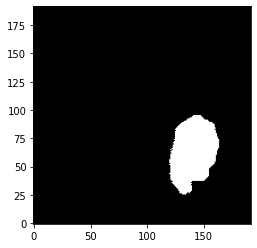

In [21]:
plt.imshow(output_array[1], cmap="gray", origin="lower")

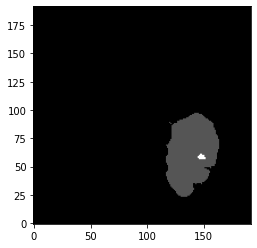

In [19]:
plt.imshow(sample_batch['label'][0,0,70,:,:], cmap="gray", origin="lower")